# Single Shot Detection (SSD)

## Utilizando Yolo com OpenCV

Iremos utilizar o classificador Yolo em conjunto com o OpenCV para lidar com inferências estáticas de imagens, vídeos e também em tempo real.

Alguns exemplos foram adaptados deste [artigo](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/) de Adrian Rosebrock.

O efeito transparente nos retângulos delimitadores foram retirados deste [gist](https://gist.github.com/IAmSuyogJadhav/305bfd9a0605a4c096383408bee7fd5c) de Suyog Jadhav.

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
print(cv2.__version__)

#Pop-up do Matplotlib
#%matplotlib qt

#Exibição na mesma tela do Jupyter
%matplotlib inline

#plt.rcParams["figure.figsize"]\
#(8,5)

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

/Users/michel.fernandes/anaconda/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


3.4.2


Carregando as informações do modelo Yolo, que são: os labels, provenientes de um conjunto de dados fornecido pelo Coco, os pesos, que é o classificador já treinado, pronto para uso e um arquivo final de configurações.

In [2]:
# Carregar os labels do conjunto de dados Coco
label_path = os.path.sep.join(["data", "coco.names"])
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path = os.path.sep.join(["pesos", "yolov3.weights"])
config_path = os.path.sep.join(["cfg", "yolov3.cfg"])

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Classificadores SSD (Single Shot Detection) possuem dois tipos de calibração básico. O primeiro é o limiar de confiança, quanto maior este limiar menor será o número de objetos identificados, pois ficará mais restrito aos objetos somente com maior confiança. O segundo, o NMS (Non-Maxima Supression), ou supressão não máxima, que é um parâmetro para controlar a sensibilidade em imagens com baixa luminosidade.

In [3]:
conf_threshold = 0.5
nms_threshold = 0.5

A função a seguir irá identificar os objetos em uma imagem (ou frame) e desenhar os *bounding boxes* nela, retornando a mesma imagem.

In [4]:
def identificar_objetos(frame):
    
    (H, W) = frame.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # Normalizando a imagem (fator de escala, tamanho, RGB/BGR)
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),  swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # Inicialização das bounding boxes
    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:
        for detection in output:
            # Extração de pontuação e confiança
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filtrar somente o que for maior que o limiar de confiança
            if confidence > conf_threshold:
                
                # Definição do bounding box encontrado

                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Aplicação do NMS (Non-Maxima Suppression) para eliminar overlapping de bounding boxes
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            # Após o filtro por NMS, desenhar os bounding boxes
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in cores[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    return frame

Vamos fazer rum teste com uma imagem estática.

In [15]:
imagem_inferencia = cv2.imread("imagens/spacecup.jpg")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)
(width, height) = imagem_inferencia.shape[:2]

Text(0.5,1,'Imagem Inferida')

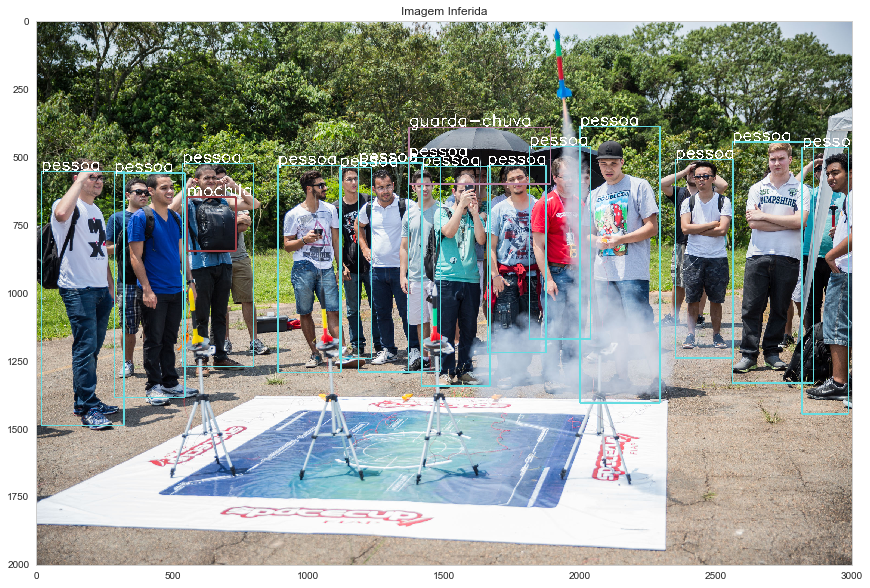

In [16]:
imagem = identificar_objetos_alpha(imagem_inferencia)

imagem_example = cv2.cvtColor(imagem, cv2.COLOR_RGB2BGR)
cv2.imwrite("imagens/spacecup_inf_readme.png", imagem_example)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Imagem Inferida")

O classificador também funciona com vídeos. Há duas formas de trabalharmos. A primeira é gravarmos um vídeo e processar posteriormente um novo vídeo. A segunda, é classificar em tempo real os objetos, mas neste caso se perdem muitos frames pois o CPU não é capaz de classificar adequadamente em tempo real.

### Gravando um vídeo

A função abaixo gravará 120 frames de um vídeo, o que dá aproximadamente 5 segundos.

In [83]:
#cam.release()
cam = cv2.VideoCapture(0)
contador = 0
writer = None
try:
    while(True):
        contador = contador + 1
        
        if contador > 120:
            cam.release()
            break
        
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            (width, height) = imagem.shape[:2]
            
            if writer is None:
                # initialize our video writer
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter("videos/rec-teste-1.avi", fourcc, 30, (imagem.shape[1], imagem.shape[0]), True)
            
            writer.write(imagem)
 
        else:
            cam.release()
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

A seguir, é um algoritmo que irá ler frame a frame de um vídeo, processar e escrever outro vídeo com as classificações e bounding boxes desenhados.

In [89]:
#cam.release()
cam = cv2.VideoCapture("videos/walking.avi")
writer = None
try:
    while(True):
        
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            frame = identificar_objetos(imagem)
           
            if writer is None:
                # initialize our video writer
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter("teste5.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), True)

            # write the output frame to disk
            writer.write(frame)
           
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

### Classificando em tempo real

Já neste exemplo, iremos classificar frame a frame. Note que há um delay bem grande entre cada frame, evidenciando que o processador não é capaz de lidar com inferência em tempo real.

Text(0.5,1,'Realtime')

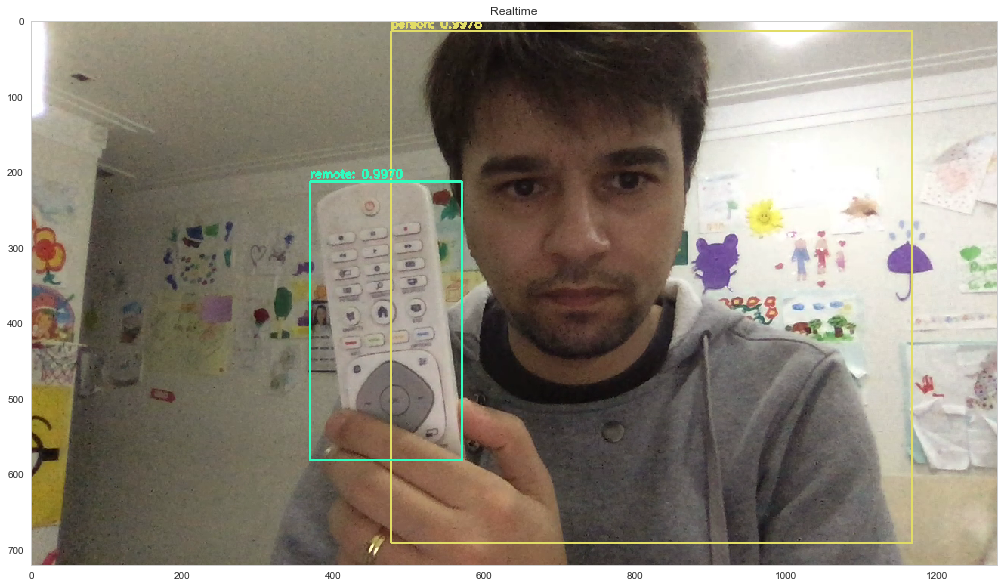

In [6]:
imagem_inferencia = cv2.imread("imagens/camera_output_3.png")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem_inferencia)
plt.title("Realtime")

### Windows

In [ ]:
cam_capture = cv2.VideoCapture(0)

while True:
    ret, image_frame = cam_capture.read()
    
    if ret:
        image_frame = identificar_objetos(image_frame)
        cv2.imshow("Objetos", transformacao_tracos(image_frame))
    
    if cv2.waitKey(1) == 13:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

### MacOS

In [7]:
#cam.release()
cam = cv2.VideoCapture(0)
writer = None

    while(True):
        
        class_ids = []
        confidences = []
        boxes = []
        
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            imagem = identificar_objetos(imagem)
            #cv2.imwrite("imagens/camera_output_3.png", imagem)
            imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
            
            img = PIL.Image.fromarray(imagem, "RGB")
            buffer = BytesIO()
            img.save(buffer,format="JPEG")        
            display(Image(data=buffer.getvalue()))
            
            clear_output(wait=True)
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

Interrompido
